In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

In [2]:
!ls data/

SPY_5min_2022-01-03T09.00.00_2022-03-25T14.10.00.csv
SPY_5min_2022-01-03T09.00.00_2022-03-25T14.10.00.csv.7z
X_test.npy
X_train.npy
y_test.npy
y_train.npy


In [3]:
file_loc = 'SPY_5min_2022-01-03T09.00.00_2022-03-25T14.10.00.csv'
df = pd.read_csv(os.path.join('data',file_loc),parse_dates=['datetime'])
df.head()

,datetime,volume,volume_weighted,open,close,high,low,timestamp,no_transactions
0,2022-01-03 09:00:00,9426.0,476.6581,476.38,476.56,476.92,476.38,1641200400000,115
1,2022-01-03 09:05:00,1778.0,476.4585,476.48,476.44,476.49,476.44,1641200700000,37
2,2022-01-03 09:10:00,9767.0,476.7624,476.62,476.83,476.87,476.58,1641201000000,80
3,2022-01-03 09:15:00,1743.0,476.7269,476.84,476.53,476.84,476.53,1641201300000,44
4,2022-01-03 09:20:00,1037.0,476.7011,476.65,476.82,476.82,476.62,1641201600000,21


<AxesSubplot:xlabel='datetime'>

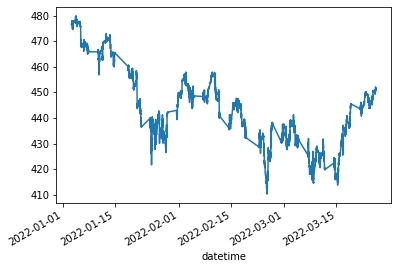

In [4]:
df.set_index('datetime')['close'].plot()

In [5]:
df['time-delta'] = df['datetime'].diff().dt.seconds
for col in ['volume','open','close','high','low']:
    df[f'{col}_diff'] = df[col].pct_change()
df.head()

,datetime,volume,volume_weighted,open,close,high,low,timestamp,no_transactions,time-delta,volume_diff,open_diff,close_diff,high_diff,low_diff
0,2022-01-03 09:00:00,9426.0,476.6581,476.38,476.56,476.92,476.38,1641200400000,115,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-03 09:05:00,1778.0,476.4585,476.48,476.44,476.49,476.44,1641200700000,37,300.0,-0.811373,0.000210,-0.000252,-0.000902,0.000126
2,2022-01-03 09:10:00,9767.0,476.7624,476.62,476.83,476.87,476.58,1641201000000,80,300.0,4.493251,0.000294,0.000819,0.000797,0.000294
3,2022-01-03 09:15:00,1743.0,476.7269,476.84,476.53,476.84,476.53,1641201300000,44,300.0,-0.821542,0.000462,-0.000629,-0.000063,-0.000105
4,2022-01-03 09:20:00,1037.0,476.7011,476.65,476.82,476.82,476.62,1641201600000,21,300.0,-0.405049,-0.000398,0.000609,-0.000042,0.000189


In [6]:
df['time-delta'].value_counts().sort_index()

300.0      10856
600.0         49
900.0          1
1200.0         1
25500.0        1
29100.0       56
Name: time-delta, dtype: int64

In [7]:
df = df[1:]

In [8]:
300/60

5.0

In [9]:
600/60

10.0

In [10]:
900/60

15.0

In [11]:
1200/60

20.0

In [12]:
25500/60

425.0

In [13]:
29100/60

485.0

# Creating the feature Matrix

In [14]:
# Window of data we're working with
N = df.shape[0]
print(f'{N} ticks found')

# 2 hour lookback period
LOOKBACK = 2*(60/5)

# Growth requirement
GROWTH_LIMIT = 0.005

# outcome period 30min
HORIZON = 6

X = list()
y = list()

t =1
finish = False
counter = 0
while finish is False:
    
    counter+=1
    print(f'Counter:{counter}',end='\r')
    
    # check we have enough lookback data
    if t<22:
        t+=1
        continue
    
    # check we don't have enough data left then end the cycle
    if (N - t)<5:
        finish = True
        t+=1
        continue
        
    lookback_data = df.loc[t-20:t,['volume_diff','close_diff','open_diff','high_diff','low_diff']].values
    outcome_data = df.loc[t+1:t+6,'close_diff'].sum()>GROWTH_LIMIT
    
    X.append(lookback_data)
    y.append(outcome_data)
    
    t+=1


10964 ticks found


In [15]:
y = np.array(y).reshape(-1,1)
y.shape

(10938, 1)

In [16]:
y.mean()

0.03355275187420004

In [17]:
y.sum()

367

In [18]:
X[-1].shape

(21, 5)

In [19]:
X = np.stack(X)

In [20]:
X.shape

(10938, 21, 5)

In [21]:
X_train = X[:6000]
X_test = X[6000:]

y_train = y[:6000]
y_test = y[6000:]

with open('./data/X_train.npy','wb') as f:
    np.save(f,X_train)
    
with open('./data/X_test.npy','wb') as f:
    np.save(f,X_test)
    
with open('./data/y_train.npy','wb') as f:
    np.save(f,y_train)
    
with open('./data/y_test.npy','wb') as f:
    np.save(f,X_test)

# Defining a simple CNN

In [22]:
import tensorflow as tf
from tensorflow import keras

In [23]:
X_train.shape

(6000, 21, 5)

In [24]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [25]:
X_train.shape

(6000, 21, 5)

In [26]:
x = keras.layers.Conv1D(12,3,activation='relu',input_shape=(X_train.shape[1],X_train.shape[2]))(X_train[:10])
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling1D(2)(x)
x = keras.layers.Conv1D(6,2,activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling1D(2)(x)
x = keras.layers.Flatten()(x)
#x = keras.layers.Dense(10,activation='relu')(x)
#x = keras.layers.Dense(1,activation='sigmoid')(x)
x.numpy().shape

2022-07-31 17:45:37.660390: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-31 17:45:37.660979: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 10. Tune using inter_op_parallelism_threads for best performance.


(10, 24)

In [27]:
model = keras.Sequential([
    keras.layers.Conv1D(24,2,
                        activation='relu',
                        input_shape=(X_train.shape[1],X_train.shape[2]),
                        kernel_regularizer=tf.keras.regularizers.l2(l=.1)),
    keras.layers.Conv1D(18,3,activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling1D(2),
    #keras.layers.Conv1D(6,2,activation='relu'),
    #keras.layers.BatchNormalization(),
    #keras.layers.MaxPooling1D(2),    
    keras.layers.Flatten(),
    #keras.layers.Dense(10,activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')
])

In [28]:
metrics = [
    tf.metrics.AUC(name='auc')
]

model.compile(optimizer=keras.optimizers.Adam(1e-4),loss='binary_crossentropy',metrics=metrics)

In [29]:
callbacks = [keras.callbacks.EarlyStopping(patience=500,restore_best_weights=True)]

In [30]:
history = model.fit(X_train,y_train,batch_size=50,epochs=200,verbose=2,validation_data=(X_test,y_test))

Train on 6000 samples, validate on 4938 samples
Epoch 1/200
6000/6000 - 2s - loss: 1.3415 - auc: 0.5520 - val_loss: 1.3062 - val_auc: 0.4626
Epoch 2/200
6000/6000 - 1s - loss: 1.0817 - auc: 0.6052 - val_loss: 1.1027 - val_auc: 0.5173
Epoch 3/200
6000/6000 - 1s - loss: 0.8946 - auc: 0.6227 - val_loss: 0.9406 - val_auc: 0.5502
Epoch 4/200
6000/6000 - 1s - loss: 0.7534 - auc: 0.5986 - val_loss: 0.8050 - val_auc: 0.5652
Epoch 5/200
6000/6000 - 1s - loss: 0.6432 - auc: 0.5980 - val_loss: 0.6608 - val_auc: 0.5821
Epoch 6/200
6000/6000 - 1s - loss: 0.5678 - auc: 0.5870 - val_loss: 0.5773 - val_auc: 0.5868
Epoch 7/200
6000/6000 - 1s - loss: 0.5120 - auc: 0.5922 - val_loss: 0.5195 - val_auc: 0.5886
Epoch 8/200
6000/6000 - 1s - loss: 0.4665 - auc: 0.6023 - val_loss: 0.4715 - val_auc: 0.5973
Epoch 9/200
6000/6000 - 1s - loss: 0.4296 - auc: 0.6125 - val_loss: 0.4379 - val_auc: 0.6003
Epoch 10/200
6000/6000 - 1s - loss: 0.3985 - auc: 0.6188 - val_loss: 0.4097 - val_auc: 0.6033
Epoch 11/200
6000/600

Epoch 88/200
6000/6000 - 1s - loss: 0.1376 - auc: 0.8022 - val_loss: 0.1760 - val_auc: 0.6586
Epoch 89/200
6000/6000 - 1s - loss: 0.1367 - auc: 0.8077 - val_loss: 0.1771 - val_auc: 0.6597
Epoch 90/200
6000/6000 - 1s - loss: 0.1360 - auc: 0.8108 - val_loss: 0.1749 - val_auc: 0.6618
Epoch 91/200
6000/6000 - 1s - loss: 0.1361 - auc: 0.8083 - val_loss: 0.1776 - val_auc: 0.6604
Epoch 92/200
6000/6000 - 2s - loss: 0.1366 - auc: 0.8046 - val_loss: 0.1761 - val_auc: 0.6603
Epoch 93/200
6000/6000 - 1s - loss: 0.1363 - auc: 0.8034 - val_loss: 0.1753 - val_auc: 0.6608
Epoch 94/200
6000/6000 - 1s - loss: 0.1360 - auc: 0.8041 - val_loss: 0.1749 - val_auc: 0.6634
Epoch 95/200
6000/6000 - 2s - loss: 0.1350 - auc: 0.8129 - val_loss: 0.1755 - val_auc: 0.6587
Epoch 96/200
6000/6000 - 2s - loss: 0.1358 - auc: 0.8021 - val_loss: 0.1766 - val_auc: 0.6593
Epoch 97/200
6000/6000 - 1s - loss: 0.1350 - auc: 0.8054 - val_loss: 0.1790 - val_auc: 0.6521
Epoch 98/200
6000/6000 - 1s - loss: 0.1346 - auc: 0.8076 - v

Epoch 175/200
6000/6000 - 1s - loss: 0.1220 - auc: 0.8357 - val_loss: 0.1740 - val_auc: 0.6494
Epoch 176/200
6000/6000 - 1s - loss: 0.1210 - auc: 0.8359 - val_loss: 0.1754 - val_auc: 0.6549
Epoch 177/200
6000/6000 - 1s - loss: 0.1204 - auc: 0.8431 - val_loss: 0.1702 - val_auc: 0.6570
Epoch 178/200
6000/6000 - 1s - loss: 0.1202 - auc: 0.8403 - val_loss: 0.1752 - val_auc: 0.6461
Epoch 179/200
6000/6000 - 1s - loss: 0.1209 - auc: 0.8320 - val_loss: 0.1743 - val_auc: 0.6522
Epoch 180/200
6000/6000 - 2s - loss: 0.1206 - auc: 0.8390 - val_loss: 0.1721 - val_auc: 0.6560
Epoch 181/200
6000/6000 - 2s - loss: 0.1203 - auc: 0.8426 - val_loss: 0.1779 - val_auc: 0.6442
Epoch 182/200
6000/6000 - 2s - loss: 0.1202 - auc: 0.8420 - val_loss: 0.1741 - val_auc: 0.6504
Epoch 183/200
6000/6000 - 1s - loss: 0.1201 - auc: 0.8443 - val_loss: 0.1712 - val_auc: 0.6544
Epoch 184/200
6000/6000 - 1s - loss: 0.1197 - auc: 0.8452 - val_loss: 0.1781 - val_auc: 0.6462
Epoch 185/200
6000/6000 - 1s - loss: 0.1200 - auc:

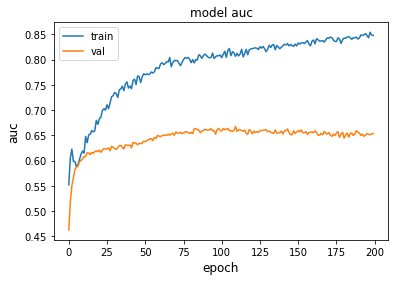

In [31]:
from matplotlib import pyplot as plt
metric = 'auc'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['train','val'],loc='best')
plt.show()

In [32]:
2*0.66-1

0.32000000000000006